# **MLBD - Assignment**

Julien Thomas - s396200, Vishal Anand Vasudevan - s388649, Théo Langé - s394369

# *Import the libraries*

In [1]:
%pip install folium geopandas pycountry altair pyspark findspark mapclassify

You should consider upgrading via the '/Users/julienthomas/Downloads/test_assignment/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Classic libraries in case we need them
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import glob
import json



# Libraries used to print maps with information on it
import folium
import branca
import geopandas as gpd
from folium.plugins import HeatMap, HeatMapWithTime
from geopy.geocoders import ArcGIS
import pycountry
import altair as alt
from collections import defaultdict


# Spark package and functions
from pyspark import SparkConf, SparkContext, SparkFiles
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, ArrayType, Row, DoubleType

import findspark
findspark.init()

# Library to ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# If you are running the entire Notebook at once, the computational time of all the tasks will be displayed at the end of the notebook
start_assignment = time.time()

# *Create the Spark Session*

In [2]:
# We first need to create a SparkSession
MAX_MEMORY = "5g"

spark = SparkSession.builder.config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory", MAX_MEMORY).getOrCreate()
sqlContext = SQLContext(spark)
spark

In [5]:
spark.stop()
#if Done

# Functions

# *Data processing*

In [3]:
'''
This function is used to process the raw dataset in order to create another Spark DataFrame with the useful information.
for each row, we will only keep the id, the timestamp, the latitude, the longitude, the altitude, the country, the sensor name, the sensor id and the P1 and P2 values.
We only keep the sensors that captured both P1 and P2.

Input : The raw dataset (Spark DataFrame)
Output : The processed dataset in the format mentionned above (Spark DataFrame)
'''


def data_process (df) :
    # First we select in each dictionary the useful information and change its type when needed 
    df = df.withColumn("latitude", df.location.latitude.cast('float')).withColumn("longitude", df.location.longitude.cast('float')).withColumn("country", when(df.location.country=='UK', 'GB').otherwise(df.location.country)).withColumn("sensor_id", df.sensor.id).withColumn("sensor_name", df.sensor.sensor_type['name'])
    
    # We explode the dictionary sensordatavalues. This will create a new line for each element in the dictionary. We can drop the dictionary afterwards
    df = df.withColumn('value_type', df.sensordatavalues.value_type)
    df = df.withColumn('P1_raw', when(array_position(df.value_type, "P1") > 0, df.sensordatavalues[array_position(df.value_type, "P1")-1].value.cast('float'))).withColumn('P2_raw', when(array_position(df.value_type, "P2") > 0, df.sensordatavalues[array_position(df.value_type, "P2")-1].value.cast('float')))
    df = df.withColumn('P1', when(df.P1_raw < 0, None).otherwise(df.P1_raw)).withColumn('P2', when(df.P2_raw < 0, None).otherwise(df.P2_raw)).drop('P1_raw', 'P2_raw')
          
    df = df.where((df.P1 >= 0) | (df.P2 >= 0))
    # This columns are now useless, we drop them
    df = df.drop('location', 'sampling_rate', 'sensor', 'datavalues', 'sensordatavalues', 'value_type')
            
    return df

In [4]:
'''
This function will plot all the sensor of the last day on a map

Input : None
Output : None, a map will be displayed
'''

def plot_sensors() :
    # This will get all the files in our data base
    files_list = glob.glob('*22.json')
    files_list.sort()

    # We select the last day and open it
    file = files_list[-1]
    spark.sparkContext.addFile(file)
        
    df = spark.read.option("multiLine",True).json(SparkFiles.get(file))
    number_sensor = df.count()
    # Then we process the raw DataFrame to select the useful information
    df = data_process(df)
        
    Sensor_position = df.select(df.latitude, df.longitude, df.country).distinct()
      
    # We will now create the map using geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    gpd_world = world[['continent', 'name', 'iso_a3']]
    
    fig, ax = plt.subplots(figsize=(17,15))
    
    # The country code in our data sets are the ISO-2 code. So we need to convert the ISO-3 code of the GeoPandas DataFrame
    iso_a2 = []
    for i in range(len(gpd_world.values)) :
        A3 = gpd_world.values[i,-1]
        
        if A3 != '-99' : # This country is the Kosovo and is not recognise by the Python library. This country doesn't have any sensor anyway.
            country = pycountry.countries.get(alpha_3 = A3)
            
            if type(country) != type(None) :
                iso_a2.append([gpd_world.values[i,0], gpd_world.values[i,1], country.alpha_2])
    
    # We can then create the new DataFrame with the ISO-2 code
    gpd_world2 = gpd.GeoDataFrame(iso_a2, columns = ["continent", 'name', 'country'])
    
    pandas_df = Sensor_position.toPandas()
    
    # We merge our DatFrame with the GeoPandas one
    pandas_df = gpd_world2.merge(pandas_df, on='country')
    
    # We can then define what will be plot on the map
    gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df["longitude"], pandas_df["latitude"]), crs="epsg:4386")

    # We plot each continent in grey, all the boundaries in black and each sensor locations as bluepoints
    world.plot('continent', ax = ax, color='#e4e4e4')
    world.boundary.plot(ax = ax, color='black')
    gdf.plot('continent', ax = ax)
    print('Position of all sensors for the last day in our database:')

    plt.show();
    
    print(f"\nNumber of sensors in the raw data for the last day : {number_sensor}")
    print(f"Number of sensors that captured P1 and\or P2 for the last day: {df.count()}")
    print(f"These sensors are distributed in {df.groupBy('country').count().count()} countries")
    if int(file[12:14]) < 10 :
        if file[15:17] == '11' :
            print(f"The majority of the sensors are located in Europe. On {int(file[13])} November, {len(pandas_df.where(pandas_df['continent'] == 'europe'))} sensors were registered in Europe")
        if file[15:17] == '12' :
            print(f"The majority of the sensors are located in Europe. On {int(file[13])} December, {len(pandas_df.where(pandas_df['continent'] == 'europe'))} sensors were registered in Europe")
    else :
        if file[15:17] == '11' :
            print(f"The majority of the sensors are located in Europe. On {int(file[12:14])} November, {len(pandas_df.where(pandas_df['continent'] == 'europe'))} sensors were registered in Europe")
        if file[15:17] == '12' :
            print(f"The majority of the sensors are located in Europe. On {int(file[12:14])} December, {len(pandas_df.where(pandas_df['continent'] == 'europe'))} sensors were registered in Europe")

## *Task 1*

In [9]:
'''
This function determines the mean AQI for each country on the dataset. First we compute the mean of the P1 and P2 values for each country.
When analysing the raw Data sets, we saw that some P1 and/or P2 values could be negative. So we need to handle this cases
Given the average P1 and P2 values for each country, we can determine the AQI for this country.
We decided to take into account the ceil value of the mean values in case they are in the middle of two AQI values.

Input : The processed DataFrame obtained with the function 'df_process' (Spark DataFrame)
Output : A Spark DataFrame containing the country, the number of sensor in this country, the current mean P1 and P2 values and the current AQI value
'''

def compute_AQI_per_country(df_process) :
    # We compute the average of P1 and P2 when the values are positives
    avgPerCountry = df_process.groupBy("country").avg('P1', 'P2').withColumnRenamed('avg(P1)', 'mean_P1').withColumnRenamed('avg(P2)', 'mean_P2')


    # We then take the ceil value of each mean in case these values are between two AQI range.
    avgPerCountry = avgPerCountry.withColumn('ceil_mean_P1', ceil('mean_P1')).withColumn('ceil_mean_P2', ceil('mean_P2'))


    # We can then determine the AQI for each country
    # First we determine the AQI value given by P1 and P2
    avgPerCountry = avgPerCountry.withColumn('AQI_1', when((0 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 16), 1) \
                                             .when((17 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 33), 2) \
                                             .when((34 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 50), 3) \
                                             .when((51 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 58), 4) \
                                             .when((59 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 66), 5) \
                                             .when((67 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 75), 6) \
                                             .when((76 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 83), 7) \
                                             .when((84 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 91), 8) \
                                             .when((92 <= avgPerCountry.ceil_mean_P1) & (avgPerCountry.ceil_mean_P1 <= 100), 9)
                                             .otherwise(10)) \
    .withColumn('AQI_2', when((0 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 11), 1) \
                .when((12 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 23), 2) \
                .when((24 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 35), 3) \
                .when((36 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 41), 4) \
                .when((42 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 47), 5) \
                .when((48 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 53), 6) \
                .when((54 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 58), 7) \
                .when((59 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 64), 8) \
                .when((65 <= avgPerCountry.ceil_mean_P2) & (avgPerCountry.ceil_mean_P2 <= 70), 9)
                .otherwise(10))
    
    # Then we can determine the highest value of AQI
    AQI = avgPerCountry.withColumn("AQI", when(avgPerCountry.AQI_1 < avgPerCountry.AQI_2, avgPerCountry.AQI_2).otherwise(avgPerCountry.AQI_1))

    
    # We add the number of sensor per country for more information about the AQI 
    sensorPerCountry = df_process.groupBy('country').count()
    sensorPerCountry = sensorPerCountry.withColumnRenamed('count', 'nb_sensor')
    
    # We add the number of sensor in this country and select only the useful Columns
    AQI = AQI.join(sensorPerCountry, AQI.country == sensorPerCountry.country).select(AQI.country, sensorPerCountry.nb_sensor, AQI.mean_P1, AQI.mean_P2, AQI.AQI)
    
    return AQI

In [10]:
'''
This function will compute the average air quality index improvement over the previous 24 hours using the two most recent files in our data base. 

Input : The data of the two days we are studying (Spark DataFrame). They sould be in the format given by the output of the function 'compute_AQI_per_country'
Output : A Spark DataFrame with the country, the number of sensor per country, the current P1 and P2 value, the current average AQI and the AQI improvement over the previous 24 hours
'''

def AQI_improvementPerCountry(df_today, df_yesterday) :
    # We first add the average AQI for the previous day to the DataFrame of the present day 
    improvement = df_today.join(df_yesterday, df_today.country == df_yesterday.country).select(df_today.country, df_today.nb_sensor, df_today.mean_P1, df_today.mean_P2, df_today.AQI, df_yesterday.AQI.alias('AQI_yesterday'))
        
    # Then we determine the improvement. We compute it so that the greater the value is, the better the improvement is. 
    # A positive value means that the current AQI is lower than the previous 24 hours. 
    improvement = improvement.withColumn('AQI_improvement', improvement.AQI_yesterday - improvement.AQI)  
    
    # We can drop the column with the AQI of the previous day as we won't need it anymore
    improvement = improvement.drop('AQI_yesterday')
    
    # We order the DataFrame according to the AQI improvement
    improvement = improvement.orderBy(improvement.AQI_improvement.desc(), 'AQI', 'country')
    
    # We add a column with the rank of the country
    improvement = improvement.withColumn('rank', monotonically_increasing_id()+1)

    
    improvement.show(10)
    return improvement

In [11]:
'''
Thid function define a html popup that will be used to print informations on a map for the task 1
Input : The row (int), and the dataframe where the information are stored (pandas DataFrame)
Output : A html function to add information to the popup window
'''

def popup_html_Q1(row, df_map):
    i = row
    country = df_map['country'].iloc[i]
    
    country2 = pycountry.countries.get(alpha_2 = country)
    country2 = country2.name
    
    nb_sensor = df_map['nb_sensor'].iloc[i]
    P1 = df_map['mean_P1'].iloc[i] 
    P2 = df_map['mean_P2'].iloc[i]
    rank = df_map['rank'].iloc[i]
    
    AQI = df_map['AQI'].iloc[i]
    AQI_improvement = df_map['AQI_improvement'].iloc[i]

    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="200px">{}</h4>""".format(country2) + """
</head>
    <table style="height: 126px; width: 350px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Country code</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(country) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Rank of the country</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(rank) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Number of sensors</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(nb_sensor) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P1</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P1) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P2</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P2) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Current AQI</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">AQI improvement</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI_improvement) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

In [12]:
'''
This function will print a map with information on it. We will print the top 10 countries in term of average air quality index improvement over the previous 24 hours
We will also use popup window to give the values of current AQI, current P1 and P2 values, the average AQI improvement as well as the number of sensor in this country
We will also add some others layer :
- The first one is a Heatmap that shows the value of AQI for the most recent days used for all the countries 
- The second one is a layer that highlight the top ten countries

Input : The Spark DataFrame where the information are stored. This DataFrame should be in the format given by the output of the function 'AQI_improvementPerCountry'. It should also be sorted by 'AQI_improvement'
Output : A map that can be printed (folium.Map)
'''

def print_map_Q1 (df) :
    # We first create the map
    world_map = folium.Map(location = [0,0], tiles="Stamen terrain", zoom_start=2)
    
    # We convert the DataFrame to a pandas DataFrame which will be used in the 'popup_html_Q1' function
    df_map = df.toPandas()
    # This command is used to find afterwards the full name of each country
    nom = ArcGIS()

    # This list will be used to print a heatmap ith the current AQI value
    heatmap = []
    
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))[['name', 'iso_a3', 'geometry']]    

    # For this question, we are interested in the top 10 countries in term of AQI improvement
    for i in range (10) :
        
        # Using this command, we can find the full name of the country
        country = pycountry.countries.get(alpha_2=df_map['country'].iloc[i])

        # We can find the coordinates of the center of the country with these lines
        if country.alpha_2 == 'TW' :
            m = nom.geocode(country.alpha_2)
            
        else :
            m = nom.geocode(country.name)
        
        # We need to create a DataFrame with a column giving the ISO3 code name for the country as well as its rank to create a layer that will give a color to the top 10 countries
        if i == 0 :
            list_countries = pd.DataFrame([[country.alpha_3, i+1]], columns = ['iso_a3', 'Rank'])
                    
        else : 
            list_countries.loc[len(list_countries)] = [country.alpha_3, i+1]

            
        # Coordinates of the center of the country
        latitude = m.latitude
        longitude = m.longitude

        
        # Thses lines define the popup window that will be displayed on the markers on the map
        html = popup_html_Q1(i, df_map)
        iframe = branca.element.IFrame(html=html,width=510,height=280)
        popup = folium.Popup(folium.Html(html, script=True), width=510, height=280)
        
        # We add a marker to the map for the top 10 countries. We also use the popup window to give more informations
        folium.Marker(location=[float(latitude), float(longitude)], 
                      popup=popup, 
                      icon=folium.Icon(color="green", icon='spinner', prefix='fa')
        ).add_to(world_map)
        

    # This part use geopandas to highlight the top 10 countries
        
        
    # We merge the GeoPandas DataFrame ith our new one
    gdf_df = world.merge(list_countries, on='iso_a3')
    gdf_df = gdf_df.sort_values(by=['Rank'])
    gdf_df = gdf_df.reset_index(drop=True)

    # Now we will define a colormap in order to give a specific color to each country according to its rank
    steps=11
    index=[i for i in range(1,11)]
    colormap = branca.colormap.LinearColormap(colors = ['green', 'red'], vmin=1, vmax=10).to_step(index=index)
    gradient_map=defaultdict(dict)
    for i in range(steps):
        gradient_map[i] = colormap.rgb_hex_str(i)
    
    Countries = folium.FeatureGroup(name='Top 10 countries', show=False)
    
    colormap.caption = 'Ranking of the country'
    colormap.add_to(world_map)

    # Display the layer on the map
    gdf_df.explore(column = 'Rank', cmap = colormap, m=Countries, legend=False, tooltip=False, color=gradient_map, style_kwds = {"fillOpacity": 1.0})


    '''
    # This for loop will create the histograms
    for i in range (len(df_map)) :
        # Using this command, we can find the full name of the country
        country = pycountry.countries.get(alpha_2=df_map['country'].iloc[i])
        
        # We can find the coordinates of the center of the country with these lines
        if country.alpha_2 == 'TW' : # Taiwan is a specific case in this package
            m = nom.geocode(country.alpha_2)
        else :
            m = nom.geocode(country.name)

            
        # Coordinates of the center of the country
        latitude = m.latitude
        longitude = m.longitude
        
        # We add the information for the heatmap to the list
        heatmap.append([latitude, longitude, df_map['AQI'].iloc[i]/10])
    
    # We define the Heatmap and add it to the map
    Heat_map = folium.FeatureGroup(name='Heat map', show=False)
    
    hm = HeatMap(np.array(heatmap),
            min_opacity=0.4,
            blur = 18, 
            show = False
           )
    '''

    # These lines will add the heatmap to the map and give control to the user whether to show the Heat map or not
    # Heat_map.add_child(hm)
    # world_map.add_child(Heat_map)
    world_map.add_child(Countries)

    world_map.add_child(folium.LayerControl())
    
    print("The map shows us the location of these 10 countries as well as some informations about the current situation.\nIt is also possible to display different layers using the panel on the top right of the window : ")
    print("- A heat map of the current AQI value for each of all of th countries ")
    print("- A layer highlighting the top 10 countries with color according to its rank. The colorbar legend corresponds to this layer")
    print("If you don't have access to the control panel, this is a bug that could come from folium of Leaflet. If you run this function again, it should be accessible")
    display(world_map)

In [13]:
'''
This function processes the data to find the top 10 countries in term of Air Quality Index improvement over the previous 24 hours.
This function will use the two last days in the database in order to determine the top 10 countries in term of AQI improvement over these two days
It will then display the results as a table and a map with differents layers


Input : None
Output : None, this function will print and show the useful tables and maps
'''

def question_1() :
    start_task = time.time()
    
    # This command give us a list with all the json files in our folder
    files_list = glob.glob('*22.json')
    files_list.sort()
    
    # We add the two files to our spark environnment and open it given the schema
    spark.sparkContext.addFile(files_list[-1])
    spark.sparkContext.addFile(files_list[-2])
    

    df_today = spark.read.option("multiLine",True).json(SparkFiles.get(files_list[-1]))
    df_yesterday = spark.read.option("multiLine",True).json(SparkFiles.get(files_list[-2]))
    
    print("The following table presents the top 10 countries in term of Air Quality improvement over 24 hours using the following json file :")
    print("    - " + files_list[-1])
    print("    - " + files_list[-2])
    
    # Then, we call the previously defined functions to process our data and find the top 10 countries in term of AQI improvement over the previous 24 hours
    AQI_today = compute_AQI_per_country(data_process(df_today))
    

    AQI_yesterday = compute_AQI_per_country(data_process(df_yesterday))
    
    # This function can determine the AQI improvement for each country and it will print out a table
    improvement_AQI = AQI_improvementPerCountry(AQI_today, AQI_yesterday)
    
    print('Creating the map ...\n')
    
    # We then print a map with markers on placed on the top 10 countries given by the previous function call
    print_map_Q1(improvement_AQI)
    
    end_task = time.time()
    print(f'It took {end_task-start_task} seconds to do this task')

## *Task 2*

In [14]:
'''
This function will create clusters given the latitude and the longitude of each sensor in a list of DataFrame. These clusters will be used for differents days.
So it is important to ensure that each sensor that appears at least on one day has an impact on the clusters positions. 
So we will first create a new DataFrame that contains all the unique location of all the sensors for all the days.
We can then create our model of clusters to apply it to predict the clusters of each days.

Input : The number of clusters we want to create (int), a list of all the DataFrames of interest. The DataFrames should be in the format of the output of the function 'data_process'
Output : The transformed DataFrame list : each DataFrame will have a new column corresponding to its cluster prediction and A Spark DataFrame with all the sensors coordinates and the cluster associated with all the coordinates
         The DataFrames with all the unique locations. This one will be used to print the clusters on a map
'''

def create_cluster(nb_cluster, df_list) :    
    # We first create a 'features' column that will be used to create our clusters
    vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
    
    # Using the list of DataFrame, we will create a new DataFrame that store the location of each distinct sensors that appeared in the period we study
    for i in range(len(df_list)) :
        df_list[i] = vecAssembler.transform(df_list[i])
        
        # We will add all the locations in one single DataFrame and then drop the duplicates location
        if i == 0 :
            df_cluster = df_list[i].select('latitude', 'longitude', 'features').distinct()
        else :
            df_cluster = df_cluster.union(df_list[i].select('latitude', 'longitude', 'features').distinct()).distinct()

    # df_cluster = spark.createDataFrame(df_cluster.rdd, schema = df_cluster.schema)
    
    # We create our model and train it using all the distinct locations
    kmeans = KMeans(k=nb_cluster, seed=12)
    model = kmeans.fit(df_cluster.select('features')) 

    
    # We will add to each row the location of the center of the corresponding cluster
    center = []
    centers = model.clusterCenters()
    for i in range (len(centers)) :
        row = centers[i]
        center.append([i,float(np.round(float(row[0]),2)), float(np.round(float(row[1]),2))])
    

    cluster_centers = spark.createDataFrame(center, ['cluster_number', 'latitude', 'longitude'])
    vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="cluster_center")
    cluster_centers = vecAssembler.transform(cluster_centers)

    # We predict the clusters for each unique location
    df_cluster = model.transform(df_cluster)
    
    # We predict the clusters of each sensors for each days
    for i in range (len(df_list)) :
        df_list[i] = model.transform(df_list[i])
        
        df_list[i] = df_list[i].withColumnRenamed("prediction", "cluster_number")
    
        # For each DataFrame, we add the cluster center as a new column
        df_list[i] = df_list[i].join(cluster_centers, df_list[i].cluster_number == cluster_centers.cluster_number).select(df_list[i].cluster_number, cluster_centers.cluster_center, df_list[i].id, df_list[i].timestamp, df_list[i].latitude, df_list[i].longitude, df_list[i].country, df_list[i].sensor_id, df_list[i].sensor_name, df_list[i].P1, df_list[i].P2)
    
    return df_list, df_cluster

In [15]:
'''
This function determine the mean AQI for each cluster on the dataset. First we compute the mean of the P1 and P2 values for each cluster.
When analysing the raw Data sets, we saw that some P1 and/or P2 values could be negative. So we need to handle this cases
Given the average P1 and P2 values for each cluster, we can determine the AQI for this country.
We decided to take into account the ceil value of the mean values in case they are in the middle of two AQI values.

Input : The processed DataFrame obtained with the function 'df_process' (Spark DataFrame)
Output : A Spark DataFrame containing the country, the current mean P1 and P2 values and the current AQI value
'''

def compute_AQI_per_cluster(df_process) :
    # We first compute the average value of P1 and P2. We just take into account positive values
    avgPerCluster = df_process.groupBy("cluster_number").avg('P1', 'P2').withColumnRenamed('avg(P1)', 'mean_P1').withColumnRenamed('avg(P2)', 'mean_P2')

    # We then add the cluster_centers to this Dataframe
    avgPerCluster = avgPerCluster.join(df_process, avgPerCluster.cluster_number == df_process.cluster_number).select(avgPerCluster.cluster_number, df_process.cluster_center, avgPerCluster.mean_P1, avgPerCluster.mean_P2)
    avgPerCluster = avgPerCluster.dropDuplicates()
    
    # We then take the ceil value of each mean in case these values are between two AQI range.
    avgPerCluster = avgPerCluster.withColumn("ceil_mean_P1", ceil('mean_P1')).withColumn("ceil_mean_P2", ceil('mean_P2'))


    # We can then determine the AQI for each country
    # First we determine the AQI value given by P1 and P2
    avgPerCluster = avgPerCluster.withColumn('AQI_1', when((0 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 16), 1) \
                                             .when((17 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 33), 2) \
                                             .when((34 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 50), 3) \
                                             .when((51 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 58), 4) \
                                             .when((59 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 66), 5) \
                                             .when((67 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 75), 6) \
                                             .when((76 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 83), 7) \
                                             .when((84 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 91), 8) \
                                             .when((92 <= avgPerCluster.ceil_mean_P1) & (avgPerCluster.ceil_mean_P1 <= 100), 9)
                                             .otherwise(10)) \
    .withColumn('AQI_2', when((0 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 11), 1) \
                .when((12 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 23), 2) \
                .when((24 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 35), 3) \
                .when((36 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 41), 4) \
                .when((42 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 47), 5) \
                .when((48 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 53), 6) \
                .when((54 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 58), 7) \
                .when((59 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 64), 8) \
                .when((65 <= avgPerCluster.ceil_mean_P2) & (avgPerCluster.ceil_mean_P2 <= 70), 9)
                .otherwise(10))
    
    
    # Then we can save only the highest value of AQI
    AQI = avgPerCluster.withColumn('AQI', when(avgPerCluster.AQI_1 < avgPerCluster.AQI_2, avgPerCluster.AQI_2).otherwise(avgPerCluster.AQI_1))
    
    # We add the number of sensor per country for more information about the AQI 
    sensorPerCluster = df_process.groupBy('cluster_number').count()
    sensorPerCluster = sensorPerCluster.withColumnRenamed('count', 'nb_sensor')
    
    # We add the number of sensor to the AQI DataFrame
    AQI = AQI.join(sensorPerCluster, AQI.cluster_number == sensorPerCluster.cluster_number).select(AQI.cluster_number, AQI.cluster_center, sensorPerCluster.nb_sensor, AQI.mean_P1, AQI.mean_P2, AQI.AQI)
    
    # We order the DataFrame to show to lower value of AQI Improvement. 
    AQI = AQI.orderBy('AQI', 'cluster_number')
    
    return AQI

In [16]:
'''
This function computes the average air quality index improvement over the previous 24 hours in order to determine the top 50 clusters in term of improvement

Input : The data of the day we are studying as well as the previous one (Spark DataFrame). They sould be in the format given by the output of the function 'compute_AQI_per_cluster'
Output : A Spark DataFrame with the cluster number, the center of this cluster, the number of sensor per cluster, the current P1 and P2 value, the current average AQI and the AQI improvement over the previous 24 hours
'''


def AQI_improvementPerCluster(df_today, df_yesterday) :
    # We first add the average AQI for the previous day to the DataFrame of the present day 
    improvement = df_today.join(df_yesterday, df_today.cluster_number == df_yesterday.cluster_number).select(df_today.cluster_number, df_today.cluster_center, df_today.nb_sensor, df_today.mean_P1, df_today.mean_P2, df_today.AQI, df_yesterday.AQI.alias('AQI_yesterday'))
        
    # Then we determine the improvement. We compute it so that the greater the value is, the better the improvement is. 
    # A positive value means that the current AQI is lower than the previous 24 hours. 
    improvement = improvement.select(improvement.cluster_number, improvement.cluster_center, improvement.nb_sensor, improvement.mean_P1, improvement.mean_P2, improvement.AQI, improvement.AQI_yesterday, improvement.AQI_yesterday - improvement.AQI)
    
    improvement = improvement.withColumnRenamed(improvement.columns[-1], 'AQI_improvement')
    
    # We can drop the column with the AQI of the previous day as we won't need it anymore
    improvement = improvement.drop('AQI_yesterday')
    
    # We order the DataFrame according to the AQI improvement. The higher the value is, the better the improvement is
    improvement = improvement.orderBy(improvement.AQI_improvement.desc(), 'AQI')
    
    # Once the DataFrame is sorted, we add a new column that corresponds to the rank of the cluster
    improvement = improvement.withColumn('rank', monotonically_increasing_id()+1)
        
    improvement.show(50)
    return improvement

In [17]:
'''
Thid function define a html popup that will be used to print informations on a map for the task 2
Input : The row (int), and the dataframe where the information are stored (pandas DataFrame)
Output : A html function to add information to the popup window
'''

def popup_html_Q2(row, df_map):
    i = row
    cluster = df_map['cluster_number'].iloc[i]
    cluster = 'Cluster n°' + str(cluster)
    cluster_center = df_map['cluster_center'].iloc[i]
    nb_sensor = df_map['nb_sensor'].iloc[i]
    Rank = df_map['rank'].iloc[i]
    P1 = df_map['mean_P1'].iloc[i] 
    P2 = df_map['mean_P2'].iloc[i] 
    
    AQI = df_map['AQI'].iloc[i]
    AQI_improvement = df_map['AQI_improvement'].iloc[i]

    left_col_color = "#19a7bd"
    right_col_color = "#f2f0d3"
    
    html = """<!DOCTYPE html>
<html>
<head>
<h4 style="margin-bottom:10"; width="200px">{}</h4>""".format(cluster) + """
</head>
    <table style="height: 126px; width: 350px;">
<tbody>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Rank of the cluster</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(Rank) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Number of sensors</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(nb_sensor) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P1</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P1) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Average P2</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(P2) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">Current AQI</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI) + """
</tr>
<tr>
<td style="background-color: """+ left_col_color +""";"><span style="color: #ffffff;">AQI improvement</span></td>
<td style="width: 150px;background-color: """+ right_col_color +""";">{}</td>""".format(AQI_improvement) + """
</tr>
</tbody>
</table>
</html>
"""
    return html

In [18]:
'''
This function will print a map with information on it. We will print the top 50 clusters in term of average air quality index improvement over the previous 24 hours
We will also use popup window to give the rank, the values of current AQI, current P1 and P2 values, the average AQI improvement as well as the number of sensor in this cluster
We will also display two different layers which can be disabled and enabled using the control panel of the map :
- A Heatmap showing the more recent AQI values of all the clusters
- The approximate clusters area. These areas have been created by connecting all the sensors in the same clusters

Input : The Spark DataFrame where the information are stored. This DataFrame should be in the format given by the output of the function 'AQI_improvementPerCountry'. 
        And another Spark DataFrame that contains the location of each distinct sensors as well as the cluster associated with the sensor
Output : A map that can be printed (folium.Map)
'''

def print_map_Q2 (df_process, df_cluster) :
    # We first create the map
    world_map = folium.Map(location = [0,0], tiles="cartodbpositron", zoom_start=2.4)

    # We convert the Spark DataFrame to a pandas DataFrame which will be used in the 'popup_html_Q2' function
    df_map = df_process.toPandas()

    # This list will be used to print a heatmap ith the current AQI value
    heatmap = []

    # We define a featureGroup in order to add all the markers to a single layer that can be disabled on the map
    Top = folium.FeatureGroup(name='Top 50 clusters')
    
    # This loop will define and create the 50 markers according to the top 50 clusters
    for i in range (50) :
        # We get the coordinates of the cluster's center
        cluster_center = df_map['cluster_center'].iloc[i]
        latitude = cluster_center[0]
        longitude = cluster_center[1]

        
        # We create and define the popup window
        html = popup_html_Q2(i, df_map)
        iframe = branca.element.IFrame(html=html,width=510,height=280)
        popup = folium.Popup(folium.Html(html, script=True), width=510, height=280)
        
        # We add a marker to the previous layer
        marker = folium.Marker(location=[float(latitude), float(longitude)], 
                      popup=popup, 
                      icon=folium.Icon(color="green", icon='spinner', prefix='fa')
        )
        
        Top.add_child(marker)
        
    
    # We create the Heatmap
    for i in range (len(df_map)) :
        # We get the coordinates of the cluster's center
        cluster_center = df_map['cluster_center'].iloc[i]
        latitude = cluster_center[0]
        longitude = cluster_center[1]
        
        # We add the information for the heatmap to the list
        heatmap.append([latitude, longitude, df_map['AQI'].iloc[i]/10])

        
    # We define the Heatmap and add it to the map
    Heat_map = folium.FeatureGroup(name='Heat map', show=False)
    
    hm = HeatMap(heatmap,
            min_opacity=0.4,
            blur = 18,
            gradient = {'0': 'Navy', '0.1' : 'Blue', '0.2' : 'Dodgerblue', '0.3' : 'Deepskyblue', '0.4': 'Cyan', '0.5': 'Limegreen', '0.6': 'Lime', '0.7': 'Yellowgreen', '0.8': 'Yellow', '0.9': 'Orange', '1': 'Red'},
            show = False
           )
    
    Heat_map.add_child(hm)

    # We will now create the layer that displays the clusters area
    pandas_df = df_cluster.toPandas()
    
    # construct geodataframe
    Clusters = folium.FeatureGroup(name='Clusters', show=False)
    gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df["longitude"], pandas_df["latitude"]), crs="epsg:4386")

    # cluster points to polygons
    gdf['prediction'] = gdf['cluster_number']

    gdf2 = gdf.dissolve(by="prediction")
    gdf2["geometry"] = gdf2["geometry"].convex_hull

    gdf2.explore(column = "cluster_number", m=Clusters, legend=False, tooltip = False, style_kwds = {"fillOpacity": 0.15})
    
    # We add all the layers to the map
    world_map.add_child(Heat_map)
    world_map.add_child(Top)
    world_map.add_child(Clusters)
    
    # We add a control panel in order to choose which layers to display on the map
    world_map.add_child(folium.LayerControl())
        
    return world_map

In [19]:
'''
This function processes the data to find the top 50 regions in term of Air Quality Index improvement over the previous 24 hours.
It will automatically choose the two most recents data sets in the data base.
This global function will call the previous defined functions.

Input : None
Output : None, this function will print and show the useful tables and maps
'''

def question_2() :
    start_task = time.time()
    # This gets the list of all the files in the folder that end with 22.json
    files_list = glob.glob('*22.json')
    files_list.sort()
    
    # We add the two files to our spark environnment and open it given the schema
    spark.sparkContext.addFile(files_list[-1])
    spark.sparkContext.addFile(files_list[-2])
    
    df_today = spark.read.option("multiLine",True).json(SparkFiles.get(files_list[-1]))
    df_yesterday = spark.read.option("multiLine",True).json(SparkFiles.get(files_list[-2]))
    
    # Then, we call the previously defined functions to process our data and find the top 50 clusters in term of AQI improvement over the previous 24 hours
    df_list = [data_process(df_today), data_process(df_yesterday)]
    df_cluster, df_cluster_total = create_cluster(200, df_list)
    
    # We compute the AQI for both days
    AQIPerCluster_today = compute_AQI_per_cluster(df_cluster[-1])
    
    AQIPerCluster_yesterday = compute_AQI_per_cluster(df_cluster[-2])
    
    print("The following table presents the top 50 clusters in term of Air Quality improvement over 24 hours using the following json file :")
    print("    - " + files_list[-1])
    print("    - " + files_list[-2])
    
    # This function can determine the AQI improvement for each cluster and it will print out a table
    improvementPerCluster_AQI = AQI_improvementPerCluster(AQIPerCluster_today, AQIPerCluster_yesterday)
    
    df_cluster_total = df_cluster_total.join(improvementPerCluster_AQI, df_cluster_total.prediction == improvementPerCluster_AQI.cluster_number).select(improvementPerCluster_AQI.cluster_number, improvementPerCluster_AQI.rank, df_cluster_total.latitude, df_cluster_total.longitude)

    # We then create the map using the previous function
    map_Q2 = print_map_Q2(improvementPerCluster_AQI, df_cluster_total)
    print("The map shows us the location of these 50 clusters as well as some informations about the current situation.\nIt is also possible to display a heat map of the current AQI value for each of these 50 clusters usign the panel on the top right of the window")
    print("- A heat map of the current AQI value for each of all of the clusters ")
    print("- A layer giving all te clusters areas. This has been determined by linking the external sensors or each clusters")
    print("If you don't have access to the control panel, this is a bug that could come from folium of Leaflet. If you run this function again, it should be accessible")
    display(map_Q2)
    
    end_task = time.time()
    print(f'It took {end_task-start_task} seconds to do this task')

## *Task 3*

In [20]:
'''
This function will print a map with information on it. We will markers with Popup windows that displays the histogram of good air quality streaks for a specific sensor
We also add two layers that can be disabled using the control panel :
- A Heatmap showing the most recent value of AQI for each cluster
- The approximate area of each cluster

Input : The Spark DataFrame where the information are stored. This DataFrame should be in the format given by the output of the function 'AQI_improvementPerCountry'
        A list we will the streaks for each clusters
        A Spark DataFrame that contains the location of each sensors to create the clusters area
Output : A map that can be printed (folium.Map)
'''

def print_map_Q3 (df_map, streak, max_streak, df_cluster) :
    # We first create the map
    world_map = folium.Map(location = [0,0], tiles="Stamen terrain", zoom_start=2.4)

    # This list will be used to print a heatmap ith the current AQI value
    heatmap = []
    
    # We define the x label legend for the histograms
    hist_legend = [i for i in range (max_streak+1)]
    
    # We create a layer which will contain all the markers. This layer will be displayed by default
    nb_cluster = folium.FeatureGroup(name = 'Histograms')
    mean_streak = np.mean(streak, axis=0)
    for i in range (len(df_map)) :
        # We get the coordinates of the cluster's center
        cluster_center = df_map['cluster_center'].iloc[i]
        latitude = cluster_center[0]
        longitude = cluster_center[1]
        
        # We add the information for the heatmap to the list
        heatmap.append([latitude, longitude, df_map['AQI'].iloc[i]/10])

        
        # We create and define the histograms
        row = streak[i]
        hist_df = pd.DataFrame(np.array([hist_legend, row, mean_streak]).T, columns=['Streaks of good days', 'number', 'mean number'])
        hist_df = hist_df.astype({'number': 'float32'})

        # We define the histograms and convert it to json in order to create the Popup
        base = alt.Chart(hist_df, title = 'Cluster n°' + str(i)).encode(x='Streaks of good days')
        
        bar = base.mark_bar().encode(y='number')
        
        line =  base.mark_line(color='red').encode(y='mean number')
        
        chart = (bar + line).properties(width=300)
        
        chart_2 = json.loads(chart.to_json())
        
        # We define a marker to the map with the popup window containing the histogram
        marker = folium.Marker(location=[float(latitude), float(longitude)], 
                      popup=folium.Popup(max_width = 500, max_height = 500).add_child(folium.features.VegaLite(chart_2, width = 400, height = 250)), 
                      icon=folium.Icon(color="green", icon='spinner', prefix='fa')
        )
        
        # We add this marker to the previous layer
        nb_cluster.add_child(marker)
    
    # We will now create the layer that display the clusters area
    df_cluster = df_cluster.drop('features')

    pandas_df = df_cluster.toPandas()
    
    # We define a layer to add the clusters area
    Cluster = folium.FeatureGroup(name='Clusters', show=False)
    
    # construct geodataframe
    gdf = gpd.GeoDataFrame(pandas_df, geometry=gpd.points_from_xy(pandas_df["longitude"], pandas_df["latitude"]), crs="epsg:4386")

    # cluster points to polygons
    gdf['cluster_number'] = gdf['prediction']

    gdf2 = gdf.dissolve(by="prediction")
    gdf2["geometry"] = gdf2["geometry"].convex_hull

    gdf2.explore(column = "cluster_number", m=Cluster, legend=False, tooltip = ['cluster_number'], style_kwds = {"fillOpacity": 0.15})
        
    # We define the Heatmap and add it to the map
    Heat_map = folium.FeatureGroup(name='Heat map', show=False)
    
    hm = HeatMap(np.array(heatmap),
            min_opacity=0.4,
            blur = 18,
            gradient = {'0': 'Navy', '0.1' : 'Blue', '0.2' : 'Dodgerblue', '0.3' : 'Deepskyblue', '0.4': 'Cyan', '0.5': 'Limegreen', '0.6': 'Lime', '0.7': 'Yellowgreen', '0.8': 'Yellow', '0.9': 'Orange', '1': 'Red'}
            )
    
    Heat_map.add_child(hm)
    
    # We add all the layers to the map and create a control panel to choose which layer to display
    world_map.add_child(Heat_map)
    world_map.add_child(nb_cluster)
    world_map.add_child(Cluster)

    world_map.add_child(folium.LayerControl())

    return world_map

In [21]:
'''
This function will retrieve the AQI of each days for each clusters in order to store it into a single DataFrame

Input : A list of processed Spark DataFrame. Each DataFrames will contain the AQI value of each 50 clusters and they all represent a specific day
Output : A Spark DataFrame where each AQI columns have been concatenated 
'''

def AQI_each_day(df_cluster) :
    # According to the previous prediction, we can compute the AQI for each clusters over all the days available in the data base
    for i in range(len(df_cluster)) :
        print(f"We are processing the day {i+1} ...")
        
        if i == 0 :  # If we are computing the AQI for the first day, we need to create the DataFrame that will store all the informations
            # We compute the AQI for each clusters
            AQIPerCluster = compute_AQI_per_cluster(df_cluster[i])
            
            AQIPerCluster = AQIPerCluster.drop('mean_P1', 'mean_P2')
            
            # Because we are just interested in the AQI range, we create a new columns of 0 and 1 which correspond respectively to a high or medium air quality index and a low air quality index
            AQIPerCluster = AQIPerCluster.select(AQIPerCluster.cluster_number, AQIPerCluster.cluster_center, AQIPerCluster.nb_sensor, AQIPerCluster.AQI, \
                                                when(AQIPerCluster.AQI <= 3, 1).otherwise(0))
            
            # We can then drop the column containing the AQI value
            AQIPerCluster = AQIPerCluster.drop('AQI')
            
            AQIPerCluster = AQIPerCluster.withColumnRenamed(AQIPerCluster.columns[-1], 'AQI_0')
            
            
        else : # When the first day is computed, we will just add the AQI information to the DataFrame created previously
            
            # We start by computing the AQi for each clusters for this day
            AQIPerCluster_i = compute_AQI_per_cluster(df_cluster[i])
            
            # Because we want to keep the AQI for the last day, we will consider two cases
            
            if i != len(df_cluster)-1 : # If this data set does not correspond to the last day, we repeat the same operations as for the first day
                AQIPerCluster_i = AQIPerCluster_i.select(AQIPerCluster_i.cluster_number, AQIPerCluster_i.AQI, \
                                                         when(AQIPerCluster_i.AQI <= 3, 1).otherwise(0))
                
                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed('cluster_number', 'cluster_number2')
                
                AQIPerCluster_i = AQIPerCluster_i.drop('AQI')
                
                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed(AQIPerCluster_i.columns[-1], 'AQI_' + str(i))        

                
            else : # If we are working on the last data set, we will store the precise AQI value
                AQIPerCluster_i = AQIPerCluster_i.select(AQIPerCluster_i.cluster_number, when(AQIPerCluster_i.AQI <= 3, 1).otherwise(0), AQIPerCluster_i.AQI)
                
                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed('cluster_number', 'cluster_number2')

                AQIPerCluster_i = AQIPerCluster_i.withColumnRenamed(AQIPerCluster_i.columns[-2], 'AQI_' + str(i))        
            
            # When the DataFrame for the day is computed, we add the AQI information to our DataFrame
            AQIPerCluster = AQIPerCluster.join(AQIPerCluster_i, AQIPerCluster.cluster_number == AQIPerCluster_i.cluster_number2)
            
            # This columns was just used to join the DataFrames
            AQIPerCluster = AQIPerCluster.drop('cluster_number2')
            
            AQIPerCluster = AQIPerCluster.orderBy('cluster_number')
    
        print('Done!')

    return AQIPerCluster

In [22]:
'''
This function will creates all the lists and parameters needed to plot the differents histograms and figure

Input : A pandas DataFrame containing in the cluster prediction and its center as well as a column for each days studied containing the AQI of the day for this specific cluster.
        These AQI columns will contain either a 0 if the AQI range is high or medium or a 1 if the AQI range is low. Finally the last column is the AQI value of the last day which will be used in a heatmap
Output : A numpy array streak2 containing the number of each streaks recorded for each clusters
         A numpy array streak_average containing all the longest streaks of each clusters
         An integer value representing the longest streak among all the clusters
'''

def histograms_list(AQI_hist) :
    # We only use the range of AQI over each days
    AQI = AQI_hist.values[:,3:-1]
    streak = []
    max_streak = 0

    # For each clusters we will get all the good days streak.
    # Each time a streak is broken, we will add a 0 to the list. This will be used to count the number of days with high or medium AQI (not consecutive days)
    for i in range (len(AQI)) :
        row = AQI[i]
        streak_i = []
        Strk = 0
        for j in range(len(row)) :
            index = row[j]

            # If the AQI is still low, the streak is not broken
            if index == 1 : 
                Strk += 1
                
            # If the AQI is not low, there are two cases
            else : 
                if Strk != 0 : # If we were on a good days streak, the streak is broken
                    # We store the length of the streak
                    streak_i.append(Strk)
                    
                    # We add a 0 to count the number of high or medium AQI
                    streak_i.append(0)
                    
                # If we were not on a streak
                else : 
                    # We simply add 0 
                    streak_i.append(0)
                
                # The streak has been broken, we reset the streak value
                Strk = 0

            # Finally if we reached the last day and we're on a good streak, we add this value to the list of streaks
            if j == len(row)-1 and Strk != 0 : streak_i.append(Strk)
            
        # We add the list of streaks for the cluster to the global list
        max_streak = np.max([max_streak, np.max(streak_i)])
        streak.append(streak_i)
    
    # Using the previously created list, we will count the number time each streak appears
    # The first element will count the number of days in high or medium AQI
    # The last element is for streaks longer than 5 days (5 days excluded)
    streak_average = []
    for i in range (len(streak)) :
        streak_average.append(np.max(streak[i]))
        # for value in streak[i] :
            # streak_average.append(value)
            
    streak2 = []
    for x in range (len(streak)) :
        row=np.zeros(max_streak+1)
        for value in streak[x] :
            row[value] += 1 
        streak2.append(list(row))
    
    return streak2, streak_average, max_streak

In [23]:
'''
This function will implement all the steps to obtain the result for the task 3. We will first process one by one each of the days on the database.
Then we will determine if the AQI is in the low range or not for each of the days
Depending of the previous result, we will update the array 'streak' which keep in memory the previous streaks.
Using this array, we will be able to create histograms for each clusters. We will create as many buckets as the highest streak amongst all the clusters.
Each buckets will display the number of time a streak of a certain number of days is observed. The first buckets will count the number of days in the medium or high rang of AQI values

We will also display an average histogram. This histogram will display the highest streaks of all clusters

Input : None
Output : None, this function will print a map with marker and display an histogram that counts all the longest streak of each cluster
'''

def question_3 () :
    start_task = time.time()
    start = time.time()
    
    # This will get all the files in our data base
    files_list = glob.glob('*22.json')
    df_list = []
    files_list.sort()

    # Here the number of days corresponds to the number of files
    nb_days = len(files_list)
    
    # We will divide the data into 50 different clusters
    nb_cluster = 50
    

    # We open all the files and create a list of processed data sets
    for i in range (len(files_list)) :
            
        file = files_list[i]
        spark.sparkContext.addFile(file)
        
        df = spark.read.option("multiLine",True).json(SparkFiles.get(file))
        df = data_process(df)
        
        df_list.append(df)
    
    # This list of DataFrame is used to create the clusters and predict the cluster of each sensor for each DataFrame
    print('Creating the clusters...')
    df_cluster, df_cluster_total = create_cluster(nb_cluster, df_list)
    print('Done!')
    
    # This function will create a new DataFrame containing a column of AQI per days studied
    AQIPerCluster = AQI_each_day(df_cluster)
        
    end = time.time()
    print(f'It took {end-start} seconds to create the clusters, predict the clusters for each sensors each days and determine the AQI for each days')
    
    # We will now build the array that will be used to create and display the histograms
    start = time.time()
    
    print('Defining the histograms...')
    
    AQI_hist = spark.createDataFrame(AQIPerCluster.rdd, schema = AQIPerCluster.schema)
    AQI_hist = AQI_hist.toPandas()
        
    # This function will create all the lists and parameters needed for the histograms plots.
    streak2, streak_average, max_streak = histograms_list(AQI_hist)
    
    # This list will be used for a global histograms
    # We will get the highest streak for each clusters
    # The histogram will the number of clusters that share the same highest streak
    
    print("Done!")
    
    end = time.time()
    print(f'It took {end-start} seconds to create the list that will be used to plot the histograms')

    print("Creating the map ...")
    
    # We create the map
    
    world_map = print_map_Q3(AQI_hist, streak2, max_streak, df_cluster_total)
    print("Done!")
    
    # We then display the global histogram as well as the map
    fig, ax = plt.subplots(1,figsize=(12,7)) 
    plt.hist(streak_average, rwidth = 0.8, bins = np.arange(nb_days+2),align='left', density=True)
    plt.title('Longest streaks amongst all the clusters')
    plt.ylabel('Number of streak(s)')
    plt.xlabel('Maximum consecutive good days observed')
    
    ax.set_xticks(np.arange(nb_days+1));
    plt.show()
    
    display(world_map)
    
    end_task = time.time()
    print(f'It took {end_task-start_task} seconds to do this task')

# **Results**

## *Data Preprocessing*

Position of all sensors for the last day in our database:


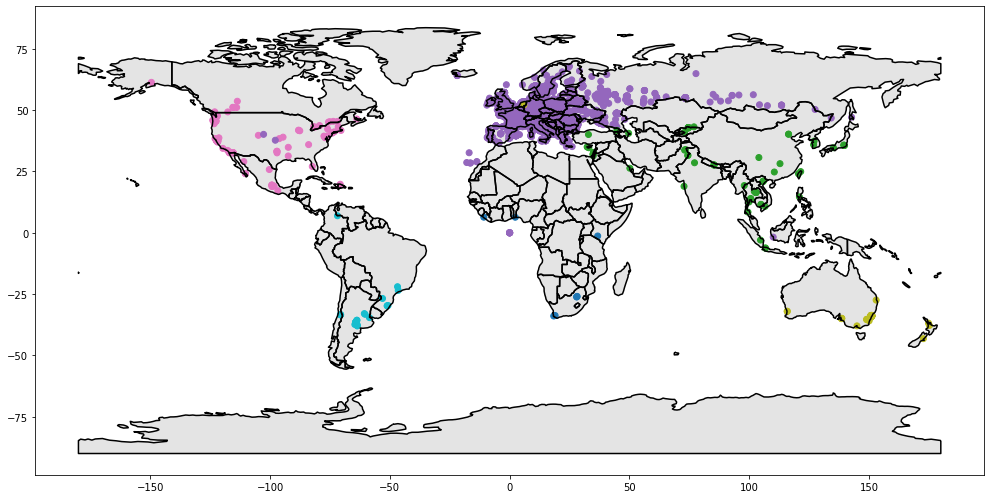


Number of sensors in the raw data for the last day : 25192
Number of sensors that captured P1 and\or P2 for the last day: 13157
These sensors are distributed in 78 countries
The majority of the sensors are located in Europe. On 28 November, 12820 sensors were registered in Europe


In [6]:
plot_sensors()

## *Task 1*

In [24]:
question_1()

22/11/28 16:30:28 WARN SparkContext: The path Data_sensor_28_11_2022.json has been added already. Overwriting of added paths is not supported in the current version.
The following table presents the top 10 countries in term of Air Quality improvement over 24 hours using the following json file :
    - Data_sensor_28_11_2022.json
    - Data_sensor_27_11_2022.json
+-------+---------+------------------+------------------+---+---------------+----+
|country|nb_sensor|           mean_P1|           mean_P2|AQI|AQI_improvement|rank|
+-------+---------+------------------+------------------+---+---------------+----+
|     BA|       17| 74.81882284669315|  42.9447054792853|  6|              4|   1|
|     AZ|        1| 7.800000190734863| 3.130000114440918|  1|              2|   2|
|     CO|        1|  6.03000020980835| 2.759999990463257|  1|              2|   3|
|     HU|      269| 80.94107873185943|39.403903889964894|  7|              2|   4|
|     AR|       15|12.621333074569701|2.93866668939590

It took 7.575143337249756 seconds to do this task


## *Task 2*

In [25]:
question_2()

22/11/28 16:30:35 WARN SparkContext: The path Data_sensor_28_11_2022.json has been added already. Overwriting of added paths is not supported in the current version.
22/11/28 16:30:35 WARN SparkContext: The path Data_sensor_27_11_2022.json has been added already. Overwriting of added paths is not supported in the current version.
22/11/28 16:30:38 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
The following table presents the top 50 clusters in term of Air Quality improvement over 24 hours using the following json file :
    - Data_sensor_28_11_2022.json
    - Data_sensor_27_11_2022.json


+--------------+---------------+---------+------------------+------------------+---+---------------+----+
|cluster_number| cluster_center|nb_sensor|           mean_P1|           mean_P2|AQI|AQI_improvement|rank|
+--------------+---------------+---------+------------------+------------------+---+---------------+----+
|           187| [12.52,100.28]|        4|13.322500348091125| 8.880000203847885|  1|              9|   1|
|            70|    [48.6,8.94]|      235| 34.27527652023004|11.860510692808857|  3|              7|   2|
|            48|   [55.52,93.2]|        4|28.325000286102295|12.205000042915344|  2|              4|   3|
|            31|  [54.34,18.52]|       60| 40.08750001589457|20.901000074545543|  3|              3|   4|
|             7|  [42.72,74.67]|       12| 77.31999989350636| 37.33749975760778|  7|              3|   5|
|            30|  [26.33,50.19]|        1| 58.38999938964844|55.130001068115234|  7|              3|   6|
|           116|  [52.21,20.99]|      248| 76.

The map shows us the location of these 50 clusters as well as some informations about the current situation.
It is also possible to display a heat map of the current AQI value for each of these 50 clusters usign the panel on the top right of the window
- A heat map of the current AQI value for each of all of the clusters 
- A layer giving all te clusters areas. This has been determined by linking the external sensors or each clusters
If you don't have access to the control panel, this is a bug that could come from folium of Leaflet. If you run this function again, it should be accessible


It took 10.302582025527954 seconds to do this task


## *Task 3*

22/11/28 16:30:51 WARN SparkContext: The path Data_sensor_27_11_2022.json has been added already. Overwriting of added paths is not supported in the current version.
22/11/28 16:30:51 WARN SparkContext: The path Data_sensor_28_11_2022.json has been added already. Overwriting of added paths is not supported in the current version.
Creating the clusters...


Done!
We are processing the day 1 ...
Done!
We are processing the day 2 ...
Done!
We are processing the day 3 ...
Done!
We are processing the day 4 ...
Done!
We are processing the day 5 ...
Done!
We are processing the day 6 ...
Done!
We are processing the day 7 ...
Done!
We are processing the day 8 ...
Done!
We are processing the day 9 ...
Done!
We are processing the day 10 ...
Done!
We are processing the day 11 ...
Done!
We are processing the day 12 ...
Done!
We are processing the day 13 ...
Done!
We are processing the day 14 ...
Done!
We are processing the day 15 ...
Done!
We are processing the day 16 ...
Done!
We are processing the day 17 ...
Done!
We are processing the day 18 ...
Done!
We are processing the day 19 ...
Done!
We are processing the day 20 ...
Done!
We are processing the day 21 ...
Done!
We are processing the day 22 ...
Done!
We are processing the day 23 ...
Done!
It took 25.873398065567017 seconds to create the clusters, predict the clusters for each sensors each days

22/11/28 16:31:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/11/28 16:31:23 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/11/28 16:31:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/11/28 16:31:24 WARN DAGScheduler: Broadcasting large task binary with size 1954.6 KiB
Done!
It took 13.091492652893066 seconds to create the list that will be used to plot the histograms
Creating the map ...


Done!


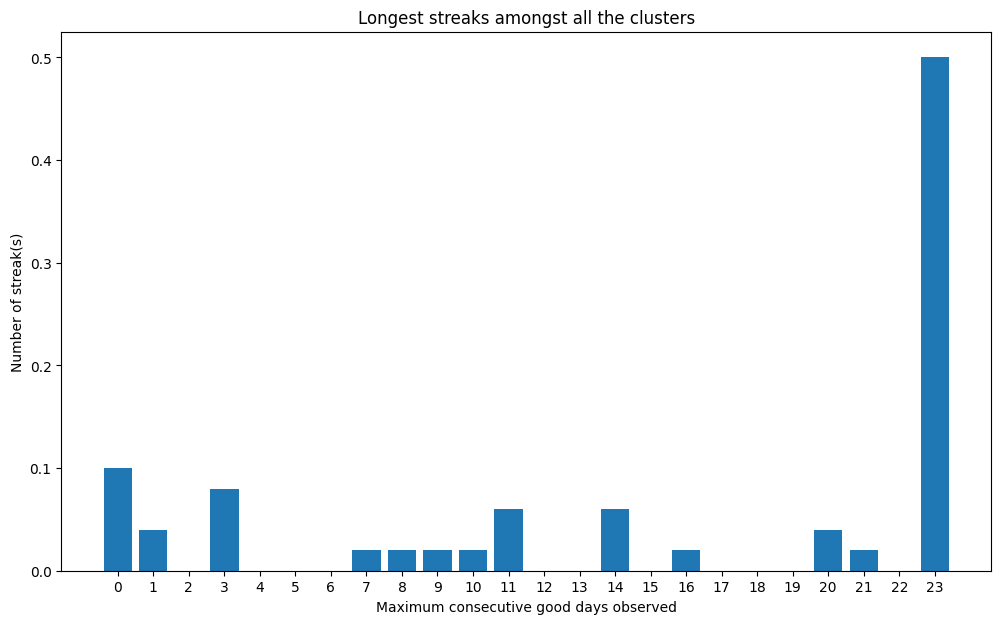

It took 45.18969488143921 seconds to do this task


In [26]:
question_3()

In [27]:
print(f"It took {time.time()-start_assignment} seconds to do all the tasks for this Assignment")

It took 71.16014504432678 seconds to do all the tasks for this Assignment


In [28]:
spark.stop()